# DAGM scratch detection using Autoencoder

Importing all the modules

In [11]:
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv2DTranspose
from keras_tqdm import TQDMNotebookCallback

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from skimage import img_as_float
from skimage.filters import gaussian
from skimage.exposure import adjust_gamma



from skimage import io
from skimage.draw import ellipse
import matplotlib.patches as pat

In [12]:
class AutoEncoder(object):
    def __init__(self, input_shape, first_layer_channels):
        self.CONV_FILTER_SIZE = 3
        self.CONV_STRIDE = 1
        self.DECONV_FILTER_SIZE = 3
        self.DECONV_STRIDE = 2

        # (32 x 32 x 1)
        inputs = Input(input_shape)

        # Creatting thhe enncoder
        # (16 x 16 x N)
        filter_count = first_layer_channels
        enc1 = self._add_encoding_layer(filter_count, inputs)

        # (8 x 8 x 2N)
        filter_count = first_layer_channels*2
        enc2 = self._add_encoding_layer(filter_count, enc1)

        # (4 x 4 x 4N)
        filter_count = first_layer_channels*4
        enc3 = self._add_encoding_layer(filter_count, enc2)

        # (8 x 8 x 2N)
        filter_count = first_layer_channels*2
        dec3 = self._add_decoding_layer(filter_count, enc3)

        # (16 x 16 x N)
        filter_count = first_layer_channels
        dec2 = self._add_decoding_layer(filter_count, dec3)

        # (32 x 32 x 1)
        filter_count = input_shape[2]
        dec1 = self._add_decoding_layer(filter_count, dec2)

        self.AutoEncoder = Model(input=inputs, output=dec1)
        print(self.AutoEncoder.summary())

    def _add_encoding_layer(self, filter_count, sequence):
        new_sequence = Conv2D(filter_count, self.CONV_FILTER_SIZE, strides=self.CONV_STRIDE, padding='same', activation='relu')(sequence)
        new_sequence = MaxPooling2D()(new_sequence)
        return new_sequence

    def _add_decoding_layer(self, filter_count, sequence):
        new_sequence = Conv2DTranspose(filter_count, self.DECONV_FILTER_SIZE, strides=self.DECONV_STRIDE, padding='same',
                                       kernel_initializer='he_uniform', activation='relu')(sequence)
        return new_sequence

    def get_model(self):
        return self.AutoEncoder

# Training

Function to load training images. We will train the model withh only good images

In [13]:
def load_train_img(num, imgdir, block_size, block_stride):
    train_rois = []
    for i in tqdm(range(1000)):
        imgpath = imgdir+str(i+1)+'.png'
        img = img_as_float(plt.imread(imgpath))
        if num ==2:
            img = adjust_gamma(img, gamma=0.1)
        if num ==6:
            img = gaussian(img, sigma=5)
        rois, _ = crop_roi(img, block_size, block_stride, True)
        train_rois += rois
    
    return np.array(train_rois).reshape(len(train_rois), block_size, block_size, 1)

Patching proocess

In [14]:
def crop_roi(img, bsize, bstride, flag):
    height, width = img.shape
    rois = []
    roi_pos = []
    if flag == True:
        # no stride in blocks
        for y in range(int(height/bsize)):
            for x in range(int(width/bsize)):
                px, py = (x*bsize, y*bsize)
                roi = img[px:px+bsize, py:py+bsize]
                if roi.shape == (bsize, bsize):
                    rois.append(roi)
                    roi_pos.append((px,py))
    else:
        # stride in blocks
        for y in range(int(height/bstride)):
            for x in range(int(width/bstride)):
                px, py = (x*bstride, y*bstride)
                roi = img[py:py+bsize, px:px+bsize]
                if roi.shape == (bsize, bsize):
                    rois.append(roi)
                    roi_pos.append((px,py))

    return rois, roi_pos

Training function

In [15]:
def train():
    # training block size and stride
    block_size = 32
    block_stride = 16
    
    # class number
    num = 2
    # train image directory
    imgdir = './Class'+str(num)+'/'
    
    train_datas = load_train_img(num, imgdir, block_size, block_stride)
    print(train_datas.shape)
    
    # Parameters
    batch_size = 32
    epochs = 10
    first_layer_channels = 32
    
    input_shape = (block_size, block_size, 1)
    auto_encoder = AutoEncoder(input_shape, first_layer_channels)
    model = auto_encoder.get_model()
    model.compile(optimizer=Adam(lr=1e-3, amsgrad=True), loss='mse')
    model.fit(train_datas, train_datas, batch_size=batch_size, epochs=epochs, verbose=0, callbacks=[TQDMNotebookCallback()])
    model.save_weights('./weights'+str(num)+'.hdf5')

In [7]:
train()

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.77it/s]


(256000, 32, 32, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0

E:\Anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


# TESTING

Labeling function

In [16]:
def load_labels(imgdir, txtpath):
    f = open(txtpath)
    lines = f.readlines()
    f.close()
    
    labels = []
    for line in lines:
        if line == 'tr':
            break
        label = list(map(float, line.split()))
        labels.append(label)
    
    masks = []
    for i in range(150):
        imgpath = imgdir+str(i+1)+'.png'
        img = io.imread(imgpath)
        
        mask = np.zeros(img.shape)
        _, c_radius, r_radius, rotaion, col, raw = labels[i]
        rr, cc = ellipse(raw, col, r_radius, c_radius, shape=mask.shape, rotation=-1*rotaion)
        mask[rr, cc] = 1
        masks.append(mask)
        
    return labels, masks

Load test image function

In [17]:
def load_test_img(num, testpath, block_size, block_stride):
    img = img_as_float(plt.imread(testpath))
    if num ==2:
        img = adjust_gamma(img, gamma=0.1)
    if num ==6:
        img = gaussian(img, sigma=5)
    test_rois, roi_pos = crop_roi(img, block_size, block_stride, False)
    
    return np.array(test_rois).reshape(len(test_rois), block_size, block_size, 1), roi_pos

Test

In [18]:
def test():
    # Network parameters
    batch_size = 32
    first_layer_channels = 32

    block_size = 32
    block_stride = 16

    num = 2
    
    imgdir = './Class'+str(num)+'_def/'
    

    txtpath = imgdir+'labels.txt'
    
    # Looad the autoencoder model
    input_shape = (block_size, block_size, 1)
    auto_encoder = AutoEncoder(input_shape, first_layer_channels)
    model = auto_encoder.get_model()
    model.load_weights('./weights'+str(num)+'.hdf5')
    
    #
    labels, masks = load_labels(imgdir, txtpath)
    
    for i in range(50):
        testpath = imgdir+str(i+1)+'.png'
        test_img = io.imread(testpath)
        test_datas, roi_pos = load_test_img(num, testpath, block_size, block_stride)
        
        pred = model.predict(test_datas)
        
        res_img = np.zeros(masks[i].shape)
        for j, pos in enumerate(roi_pos):
            x, y = pos
            res_img[y:y+block_size, x:x+block_size] = np.sum(np.abs(pred[j] - test_datas[j]))
        
        _, c_radius, r_radius, rotation, col, raw = labels[i]
        
        fig = plt.figure(figsize=(12,5))
        ax1 = fig.add_subplot(1,2,1)
        ax1.imshow(test_img, cmap='gray')
        e = pat.Ellipse(xy = (int(col), int(raw)), width = int(c_radius*2), height = int(r_radius*2), angle = int(rotation/3.14*180), fill=False, color='red')
        ax1.add_patch(e)
        ax2 = fig.add_subplot(1,2,2)
        im2 = ax2.imshow(res_img, cmap='plasma')
        fig.colorbar(im2, ax=ax2)
        plt.show()

E:\Anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 128)         0         
__________

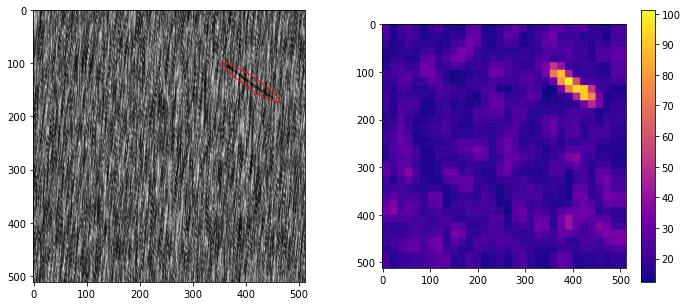

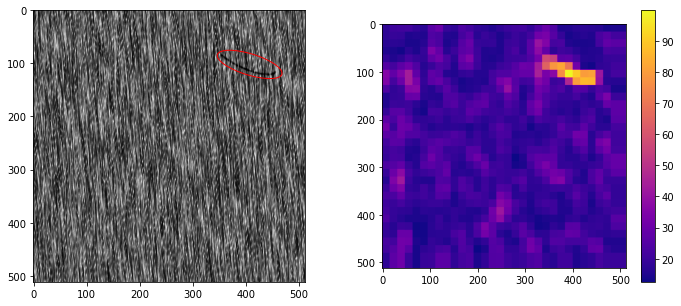

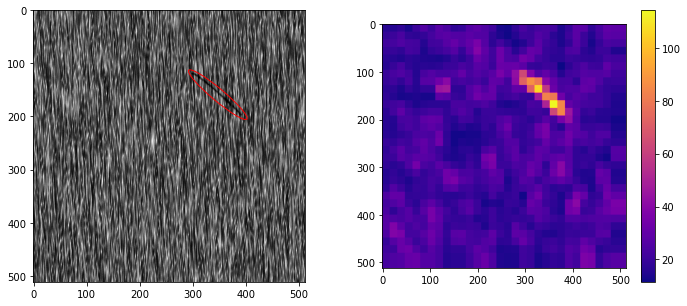

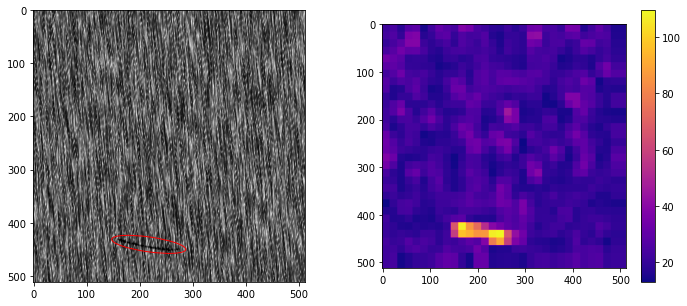

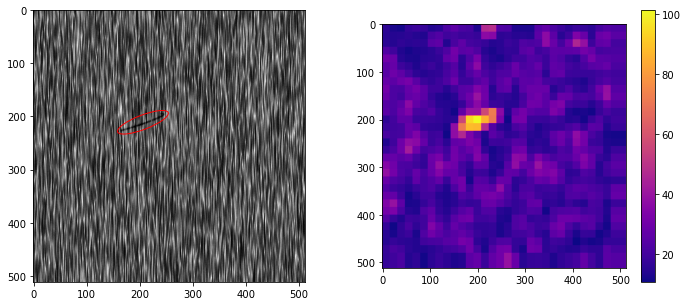

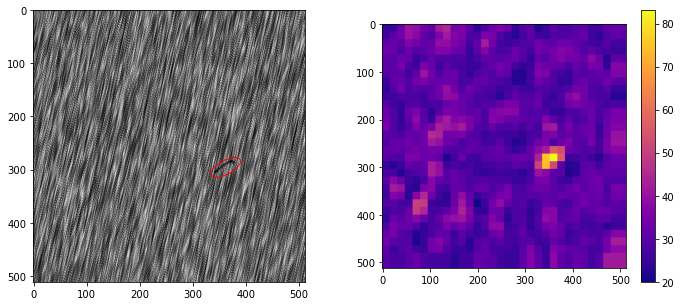

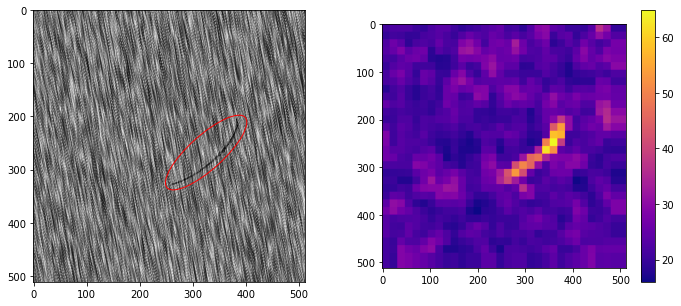

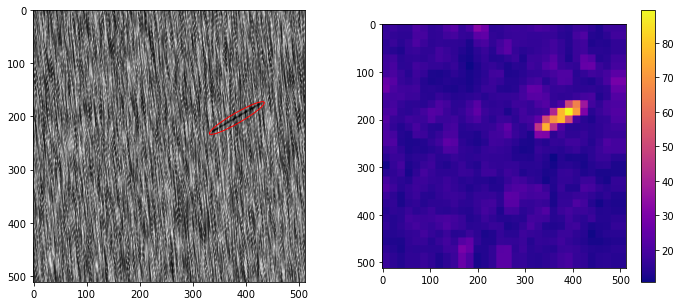

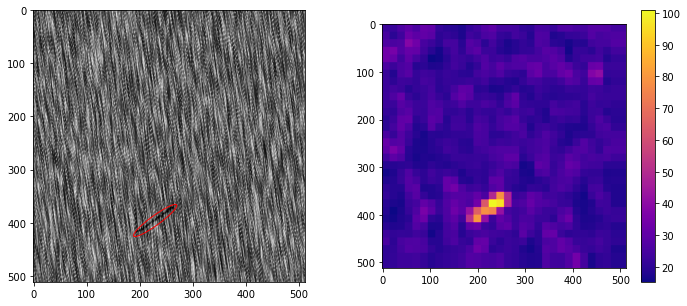

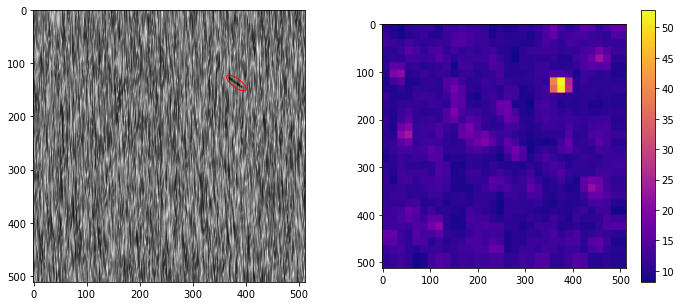

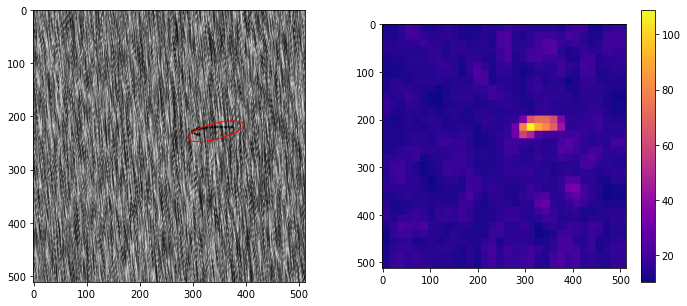

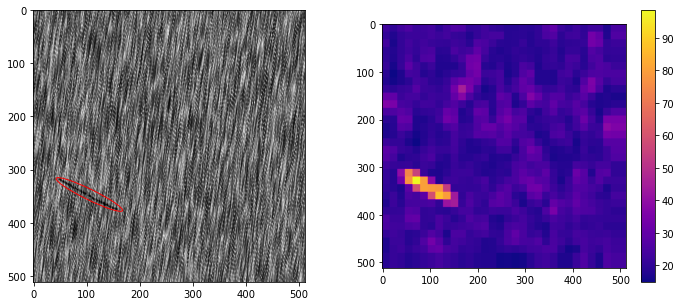

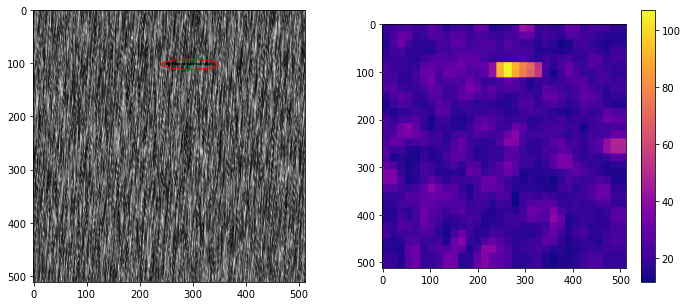

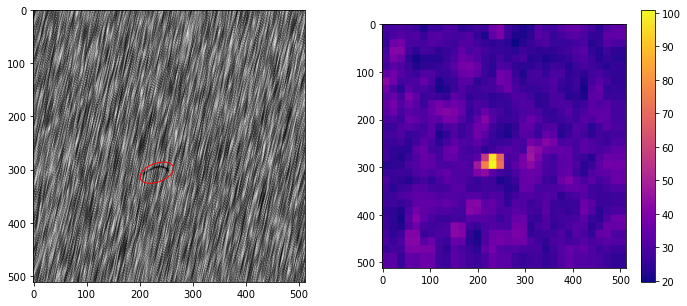

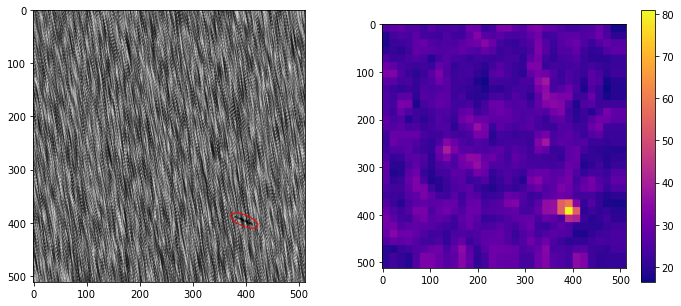

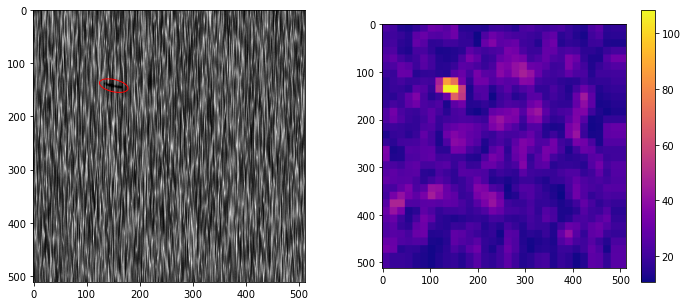

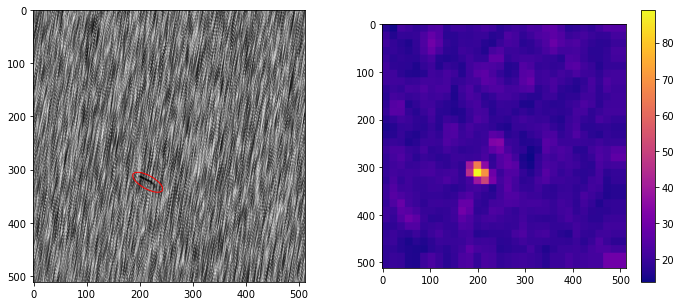

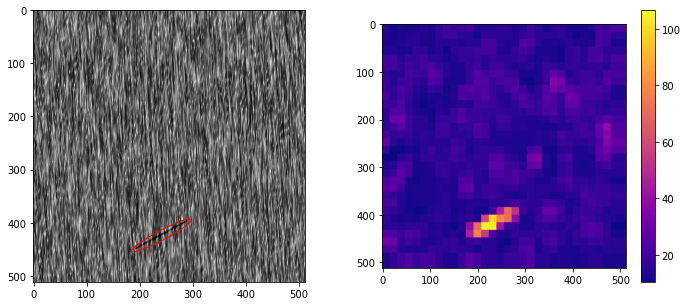

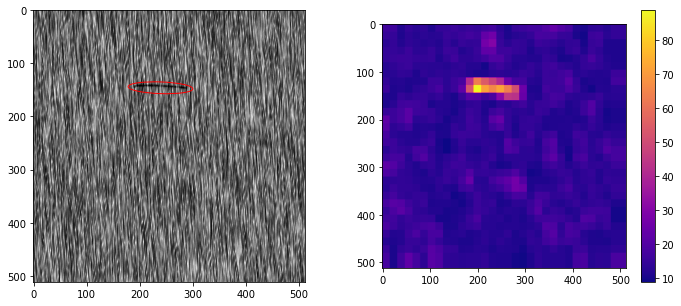

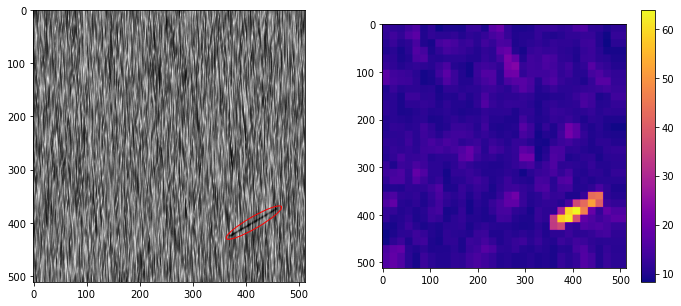

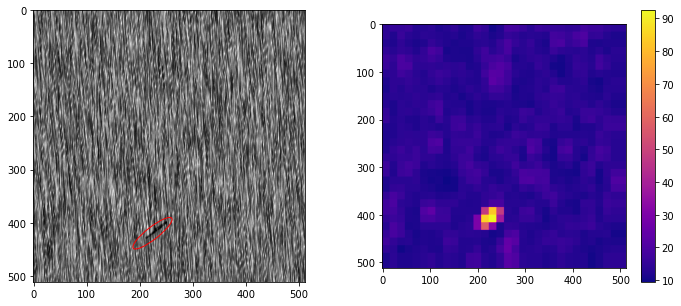

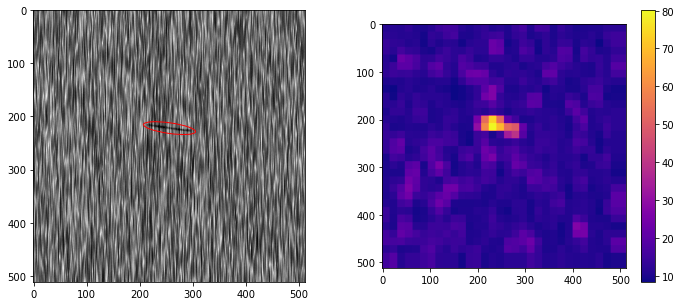

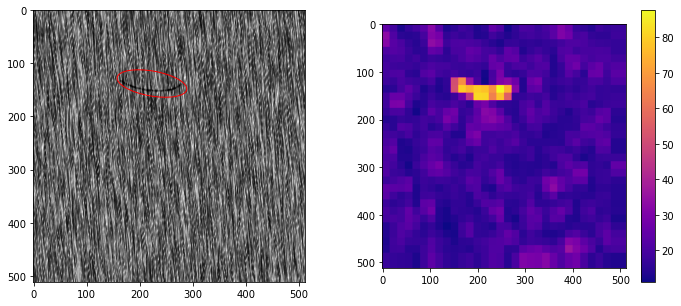

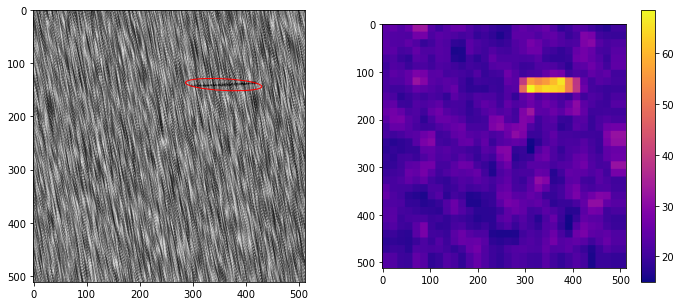

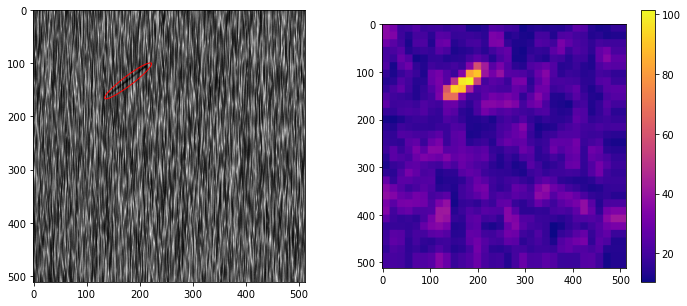

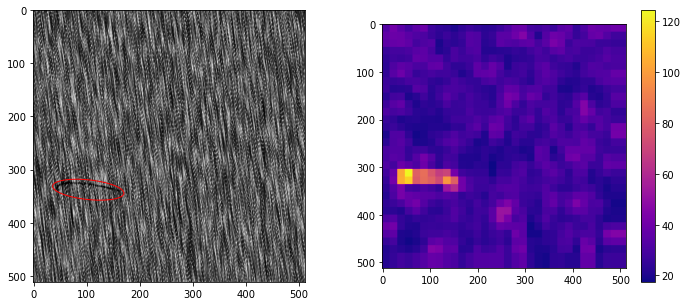

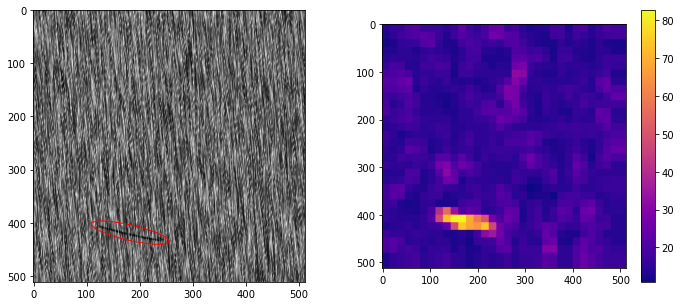

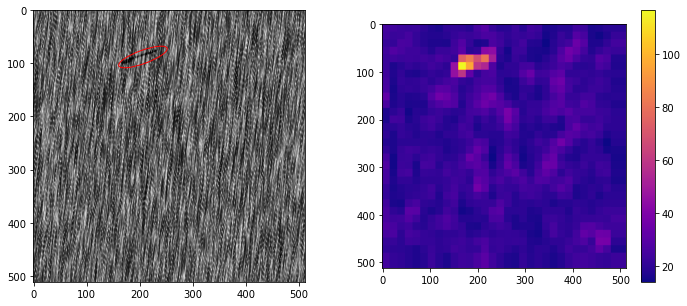

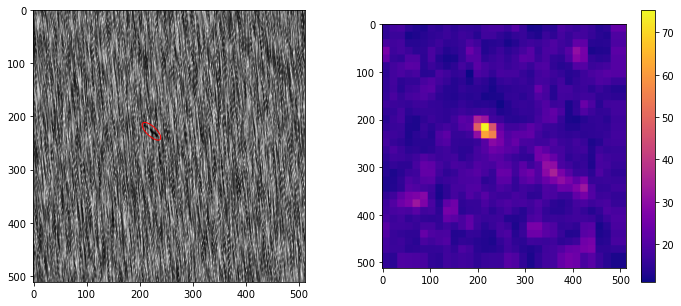

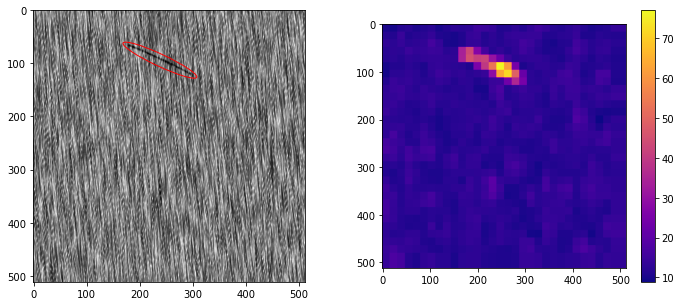

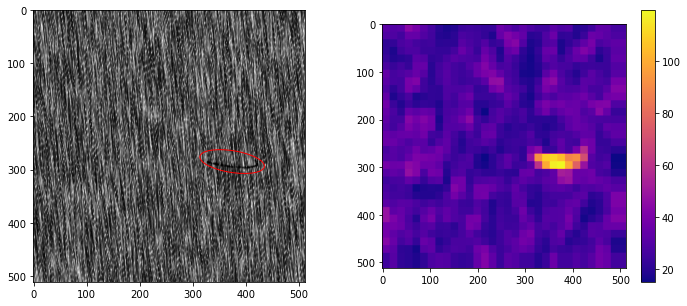

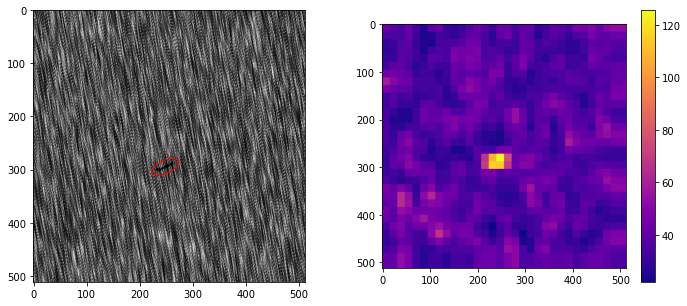

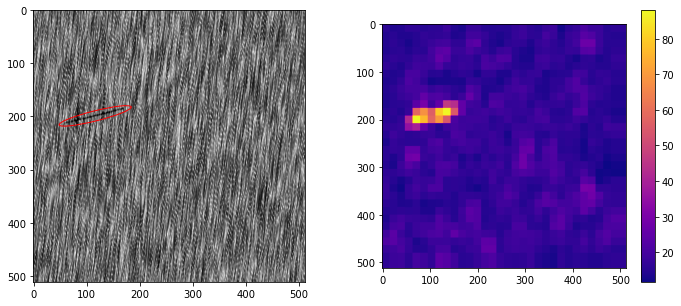

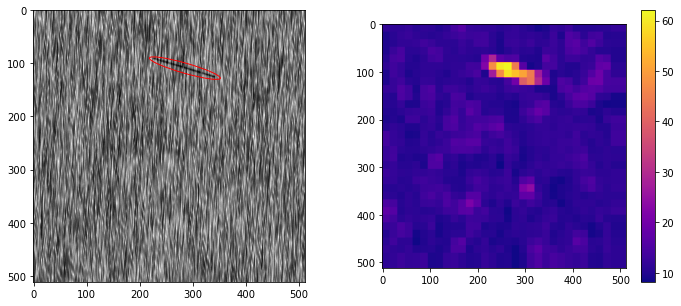

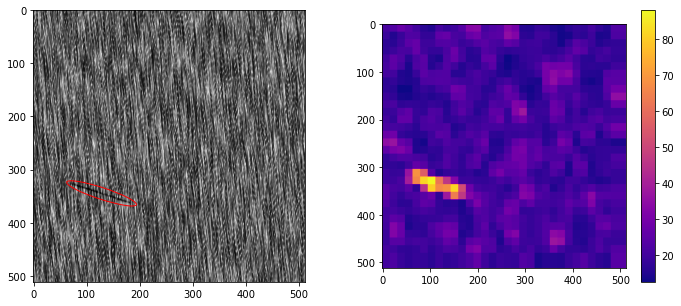

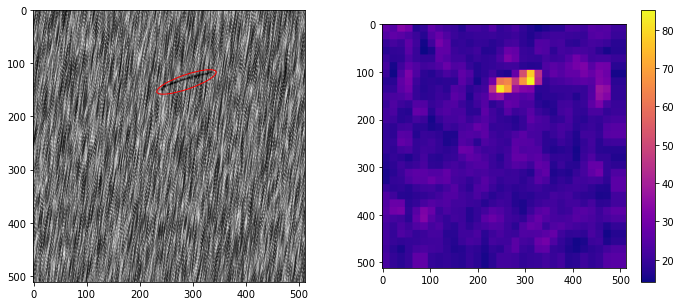

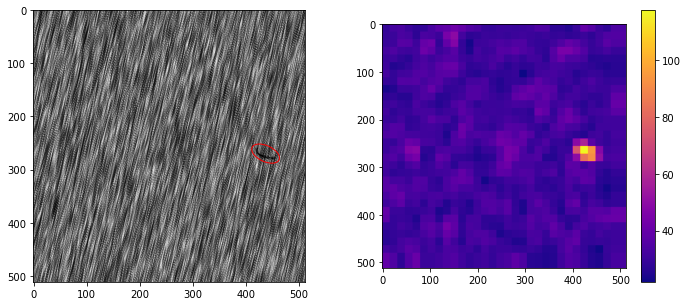

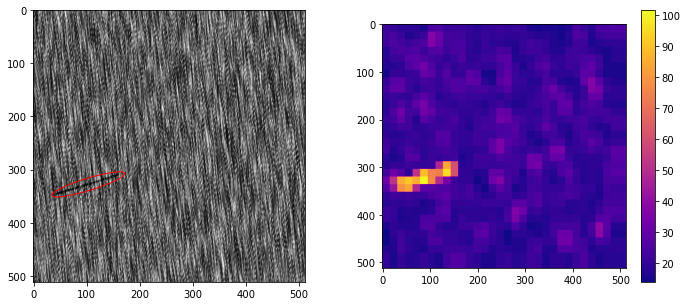

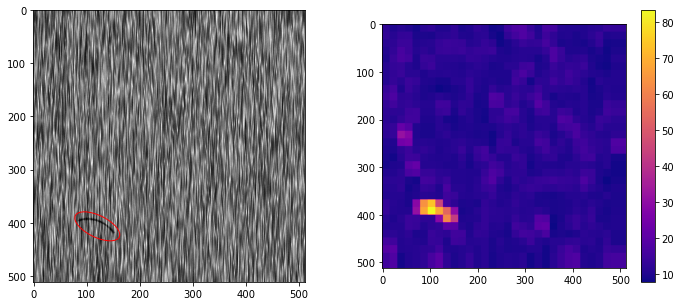

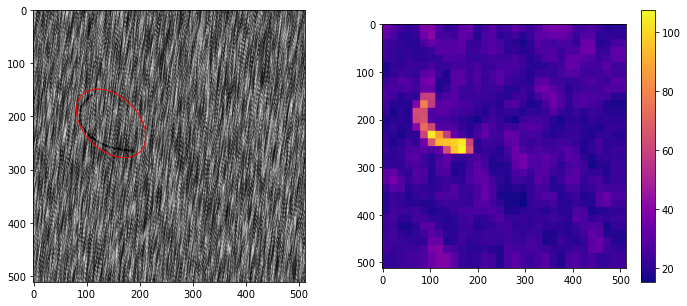

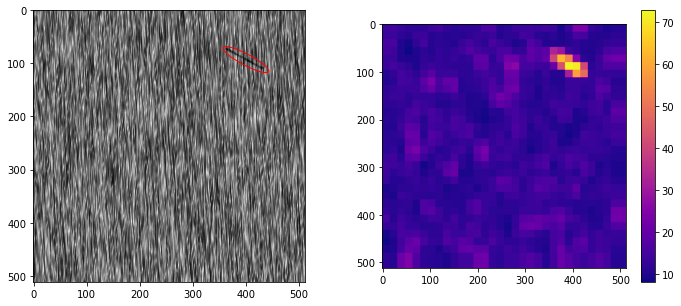

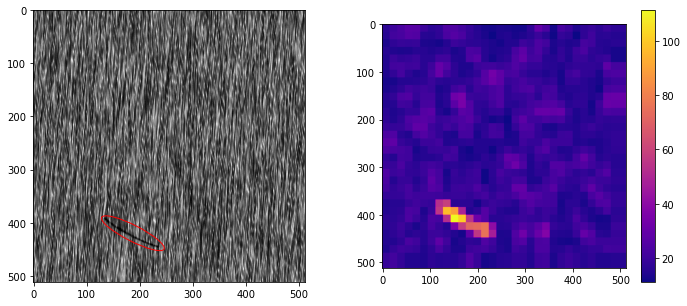

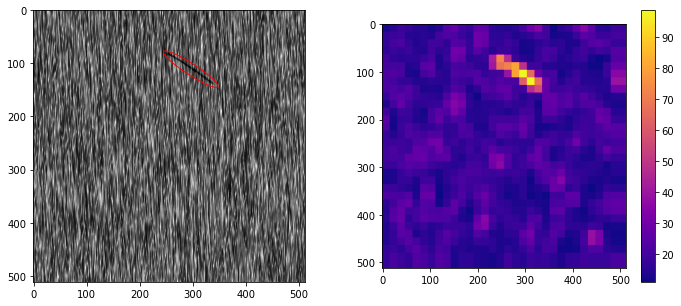

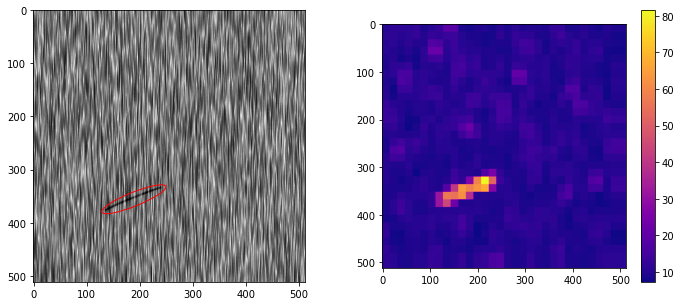

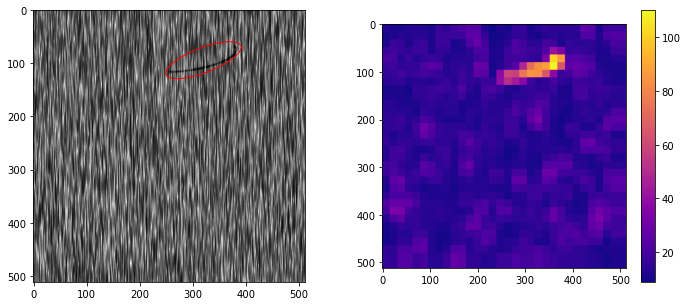

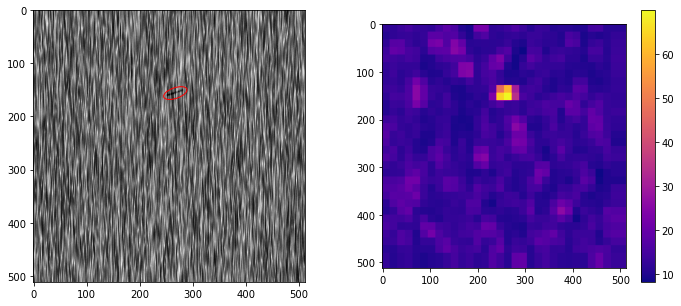

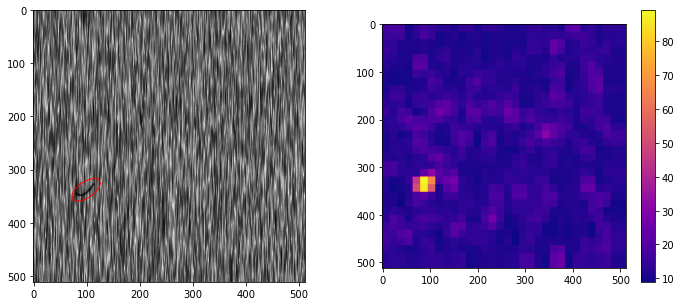

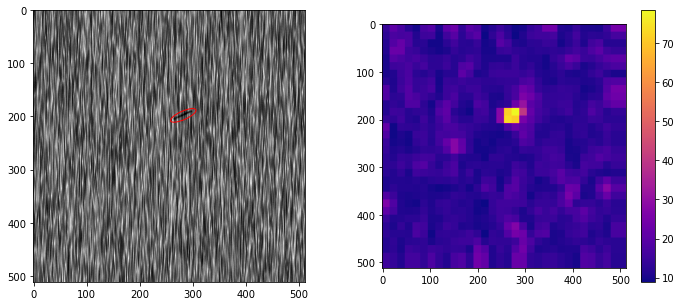

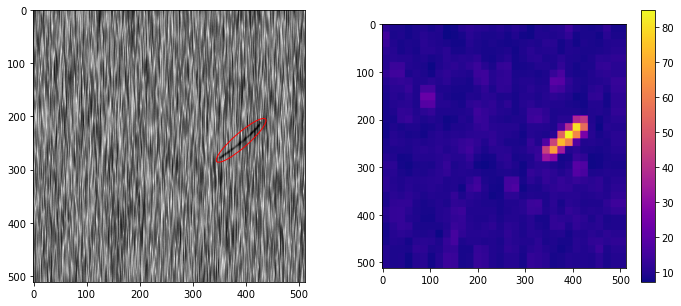

In [19]:
test()